# Import Libraries

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import dill
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats.stats import pearsonr
import math
import random
from sklearn.linear_model import Lasso,LinearRegression,ElasticNet,Ridge
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split
import altair as alt

from scipy.stats.stats import pearsonr
from sklearn.preprocessing import StandardScaler, RobustScaler


# Setting Flags

In [2]:
# setting flags
debug=False
if debug == True: 
    seed = 10 
    samples = 25000 # 25k records
else: 
    seed=np.random.randint(100000)
    samples = 100000 # 100k records

# Define Training and Scoring Data

In [3]:
raw_train_data = pd.read_pickle("./raw_train_data.pkl")
raw_test_data = pd.read_pickle("./raw_test_data.pkl")

# One Hot Encoding

In [4]:
hot_train_data = raw_train_data.copy()
hot_test_data = raw_test_data.copy()

cat_columns = ['companyId','countryId','deviceType']

hot_train_data_y = hot_train_data['y']
hot_train_data_x = hot_train_data.drop('y', axis=1)

In [5]:
hot_train_data_x = pd.get_dummies(hot_train_data_x, prefix_sep="__",columns=cat_columns)

cat_dummies = [col for col in hot_train_data_x 
               if "__" in col 
               and col.split("__")[0] in cat_columns]

processed_columns = list(hot_train_data_x.columns[:])

# Remove additional columns
for col in hot_test_data.columns:
    if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
        #print("Removing additional feature {}".format(col))
        hot_test_data.drop(col, axis=1, inplace=True)
        
for col in cat_dummies:
    if col not in hot_test_data.columns:
        #print("Adding missing feature {}".format(col))
        hot_test_data[col] = 0        
        
hot_test_data = hot_test_data[processed_columns]
#hot_train_data = hot_train_data_x.join(hot_train_data_y)
hot_train_data = hot_train_data_x
hot_train_data.shape

(213534, 29)

# Data Transformation

In [6]:
robust_scaler = RobustScaler(quantile_range=(10.0, 90.0)).fit(hot_train_data)
trans_train_data = robust_scaler.transform(hot_train_data)
trans_test_data = robust_scaler.transform(hot_test_data)
print(trans_train_data.shape)
print(trans_test_data.shape)

(213534, 29)
(30910, 29)


# Test and Train Split

In [7]:
x_train, x_cv, y_train, y_cv = train_test_split(trans_train_data,hot_train_data_y)

# Linear Regression

In [8]:
lreg = LinearRegression()
lreg.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
pred = lreg.predict(x_cv)

In [10]:
rmse = np.sqrt(np.mean((pred - y_cv)**2))
print ("RMSE is "+str(rmse))

RMSE is 1.2449583161096194


# calculating coefficients

In [11]:
hot_train_data_x.columns

Index(['price1', 'price2', 'price3', 'ad_area', 'ad_ratio', 'requests',
       'impression', 'cpc', 'ctr', 'viewability', 'companyId__126',
       'companyId__157', 'companyId__159', 'companyId__40', 'companyId__43',
       'companyId__95', 'countryId__12', 'countryId__13', 'countryId__234',
       'countryId__38', 'countryId__56', 'countryId__57', 'countryId__59',
       'countryId__77', 'countryId__other', 'deviceType__1', 'deviceType__2',
       'deviceType__3', 'deviceType__5'],
      dtype='object')

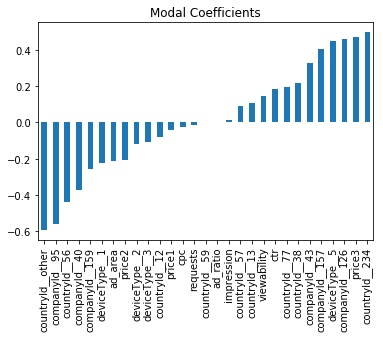

In [12]:
coeff= pd.Series(data=lreg.coef_,index=hot_train_data_x.columns).sort_values()
coeff.plot(kind='bar', title='Modal Coefficients')

In [13]:
lreg.score(x_cv,y_cv)

0.18022337321059156

Text(0.5, 1.0, 'Residual plot')

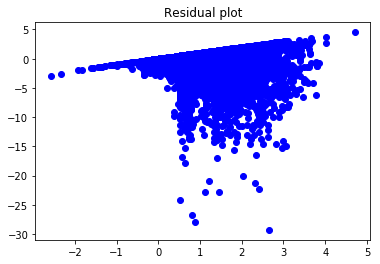

In [14]:
x_plot = plt.scatter(pred, (pred - y_cv), c='b')
#plt.hlines(y=0, xmin= -1000,xmax = 5000)
plt.title('Residual plot')

# Ridge Regression

## Defining debugging and normal parameters

In [15]:
ridgeReg = Ridge()
    
if debug == True: 
    cv_method = RepeatedKFold(n_splits=3, n_repeats=1,random_state=seed)
    parameters = {'alpha'  : [0.005,0.01,0.05],
                  'normalize'     : ['True','False']
                 }
else: 
    cv_method = RepeatedKFold(n_splits=5, n_repeats=3,random_state=seed)
    parameters = {'alpha'  : [0.0005,0.001,0.01,0.02,0.05,0.08,0.1,2,5],
                  'normalize'     : ['True','False']
                 }

## Hyper Parameter Tuning

In [16]:
grid = GridSearchCV(estimator=ridgeReg, param_grid = parameters, 
                    scoring = 'neg_mean_squared_error'  ,cv = cv_method, n_jobs=-2,
                    return_train_score=True)
grid.fit(pd.DataFrame(trans_train_data).sample(samples, random_state = seed),hot_train_data_y.sample(samples, random_state = seed))

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x000002050476A9E8>,
             error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-2,
             param_grid={'alpha': [0.0005, 0.001, 0.01, 0.02, 0.05, 0.08, 0.1,
                                   2, 5],
                         'normalize': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

## Results

In [17]:
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 Ridge(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=None,
      normalize='True', random_state=None, solver='auto', tol=0.001)

 The best score across ALL searched params:
 -1.56788743905607

 The best parameters across ALL searched params:
 {'alpha': 0.0005, 'normalize': 'True'}



In [18]:
ridgeReg = Ridge(alpha=0.0005, normalize=True)
ridgeReg.fit(trans_train_data,hot_train_data_y)

Ridge(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

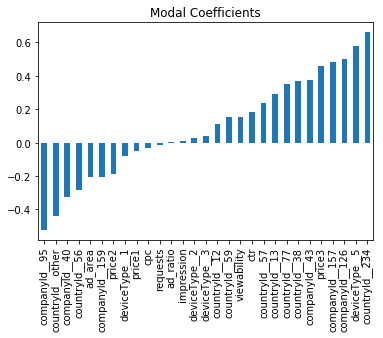

In [19]:
coeff= pd.Series(data=ridgeReg.coef_,index=hot_train_data_x.columns).sort_values()
coeff.plot(kind='bar', title='Modal Coefficients')

# Lasso Regression

## Defining debugging and normal parameters

In [20]:
lassoReg = Lasso()
    
if debug == True: 
    cv_method = RepeatedKFold(n_splits=3, n_repeats=1,random_state=seed)
    parameters = {'alpha'  : [0.0005,0.005,0.01,0.05],
                  'normalize'     : ['True','False']
                 }
else: 
    cv_method = RepeatedKFold(n_splits=5, n_repeats=3,random_state=seed)
    parameters = {'alpha'  : [0.0005,0.001,0.01,0.02,0.05,0.08,0.1,2,5],
                  'normalize'     : ['True','False']
                 }

## Hyper Parameter Tuning

In [21]:
grid = GridSearchCV(estimator= lassoReg   , param_grid = parameters, 
                    scoring = 'neg_mean_squared_error'  ,cv = cv_method, n_jobs=-2,
                    return_train_score=True)
grid.fit(pd.DataFrame(trans_train_data).sample(samples, random_state = seed),hot_train_data_y.sample(samples, random_state = seed))

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x000002050482EBE0>,
             error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-2,
             param_grid={'alpha': [0.0005, 0.001, 0.01, 0.02, 0.05, 0.08, 0.1,
                                   2, 5],
                         'normalize': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

## Results

In [22]:
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    
print("\n The best estimator across ALL searched params:\n",grid.best_estimator_)
print("\n The best score across ALL searched params:\n",grid.best_score_)
print("\n The best parameters across ALL searched params:\n",grid.best_params_)
print("\n ========================================================")


 Results from Grid Search 

 The best estimator across ALL searched params:
 Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize='True', positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

 The best score across ALL searched params:
 -1.7079127746476468

 The best parameters across ALL searched params:
 {'alpha': 0.0005, 'normalize': 'True'}



In [23]:
lassoReg = Lasso(alpha= 0.0005, normalize = 'True')
lassoReg.fit(trans_train_data,hot_train_data_y)


Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize='True', positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [24]:
lassoReg.coef_

array([ 0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.03473257,  0.        ,
        0.        ,  0.        , -0.        , -0.        ,  0.12352037,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.13447264,
       -0.        ,  0.        ,  0.        ,  0.        ])

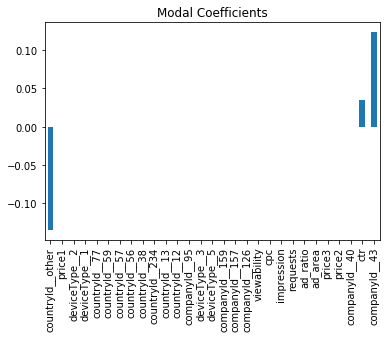

In [25]:
coeff= pd.Series(data=lassoReg.coef_,index=hot_train_data_x.columns).sort_values()
coeff.plot(kind='bar', title='Modal Coefficients')

In [ ]:
grid